In [241]:
from utils.paths_to_files import *
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_palette("Set2")
import matplotlib.pyplot as plt
import ast
from utils.utils import *
import IPython.display as ipd

# 0. Introduction
The purpose of this notebook is to clean and explore the metadata, with the aim of selecting tracks that display desirable properties. The selected tracks will then be subjected to exploratory data analysis (EDA) of their features in a separate notebook. By addressing the issues with the tracks in the metadata first, we can ensure a more focused analysis of the audio features extracted for each track.

# 1. ER Diagram
Displayed below is an ER diagram in an informal format that illustrates the relationships between entities within the metadata.

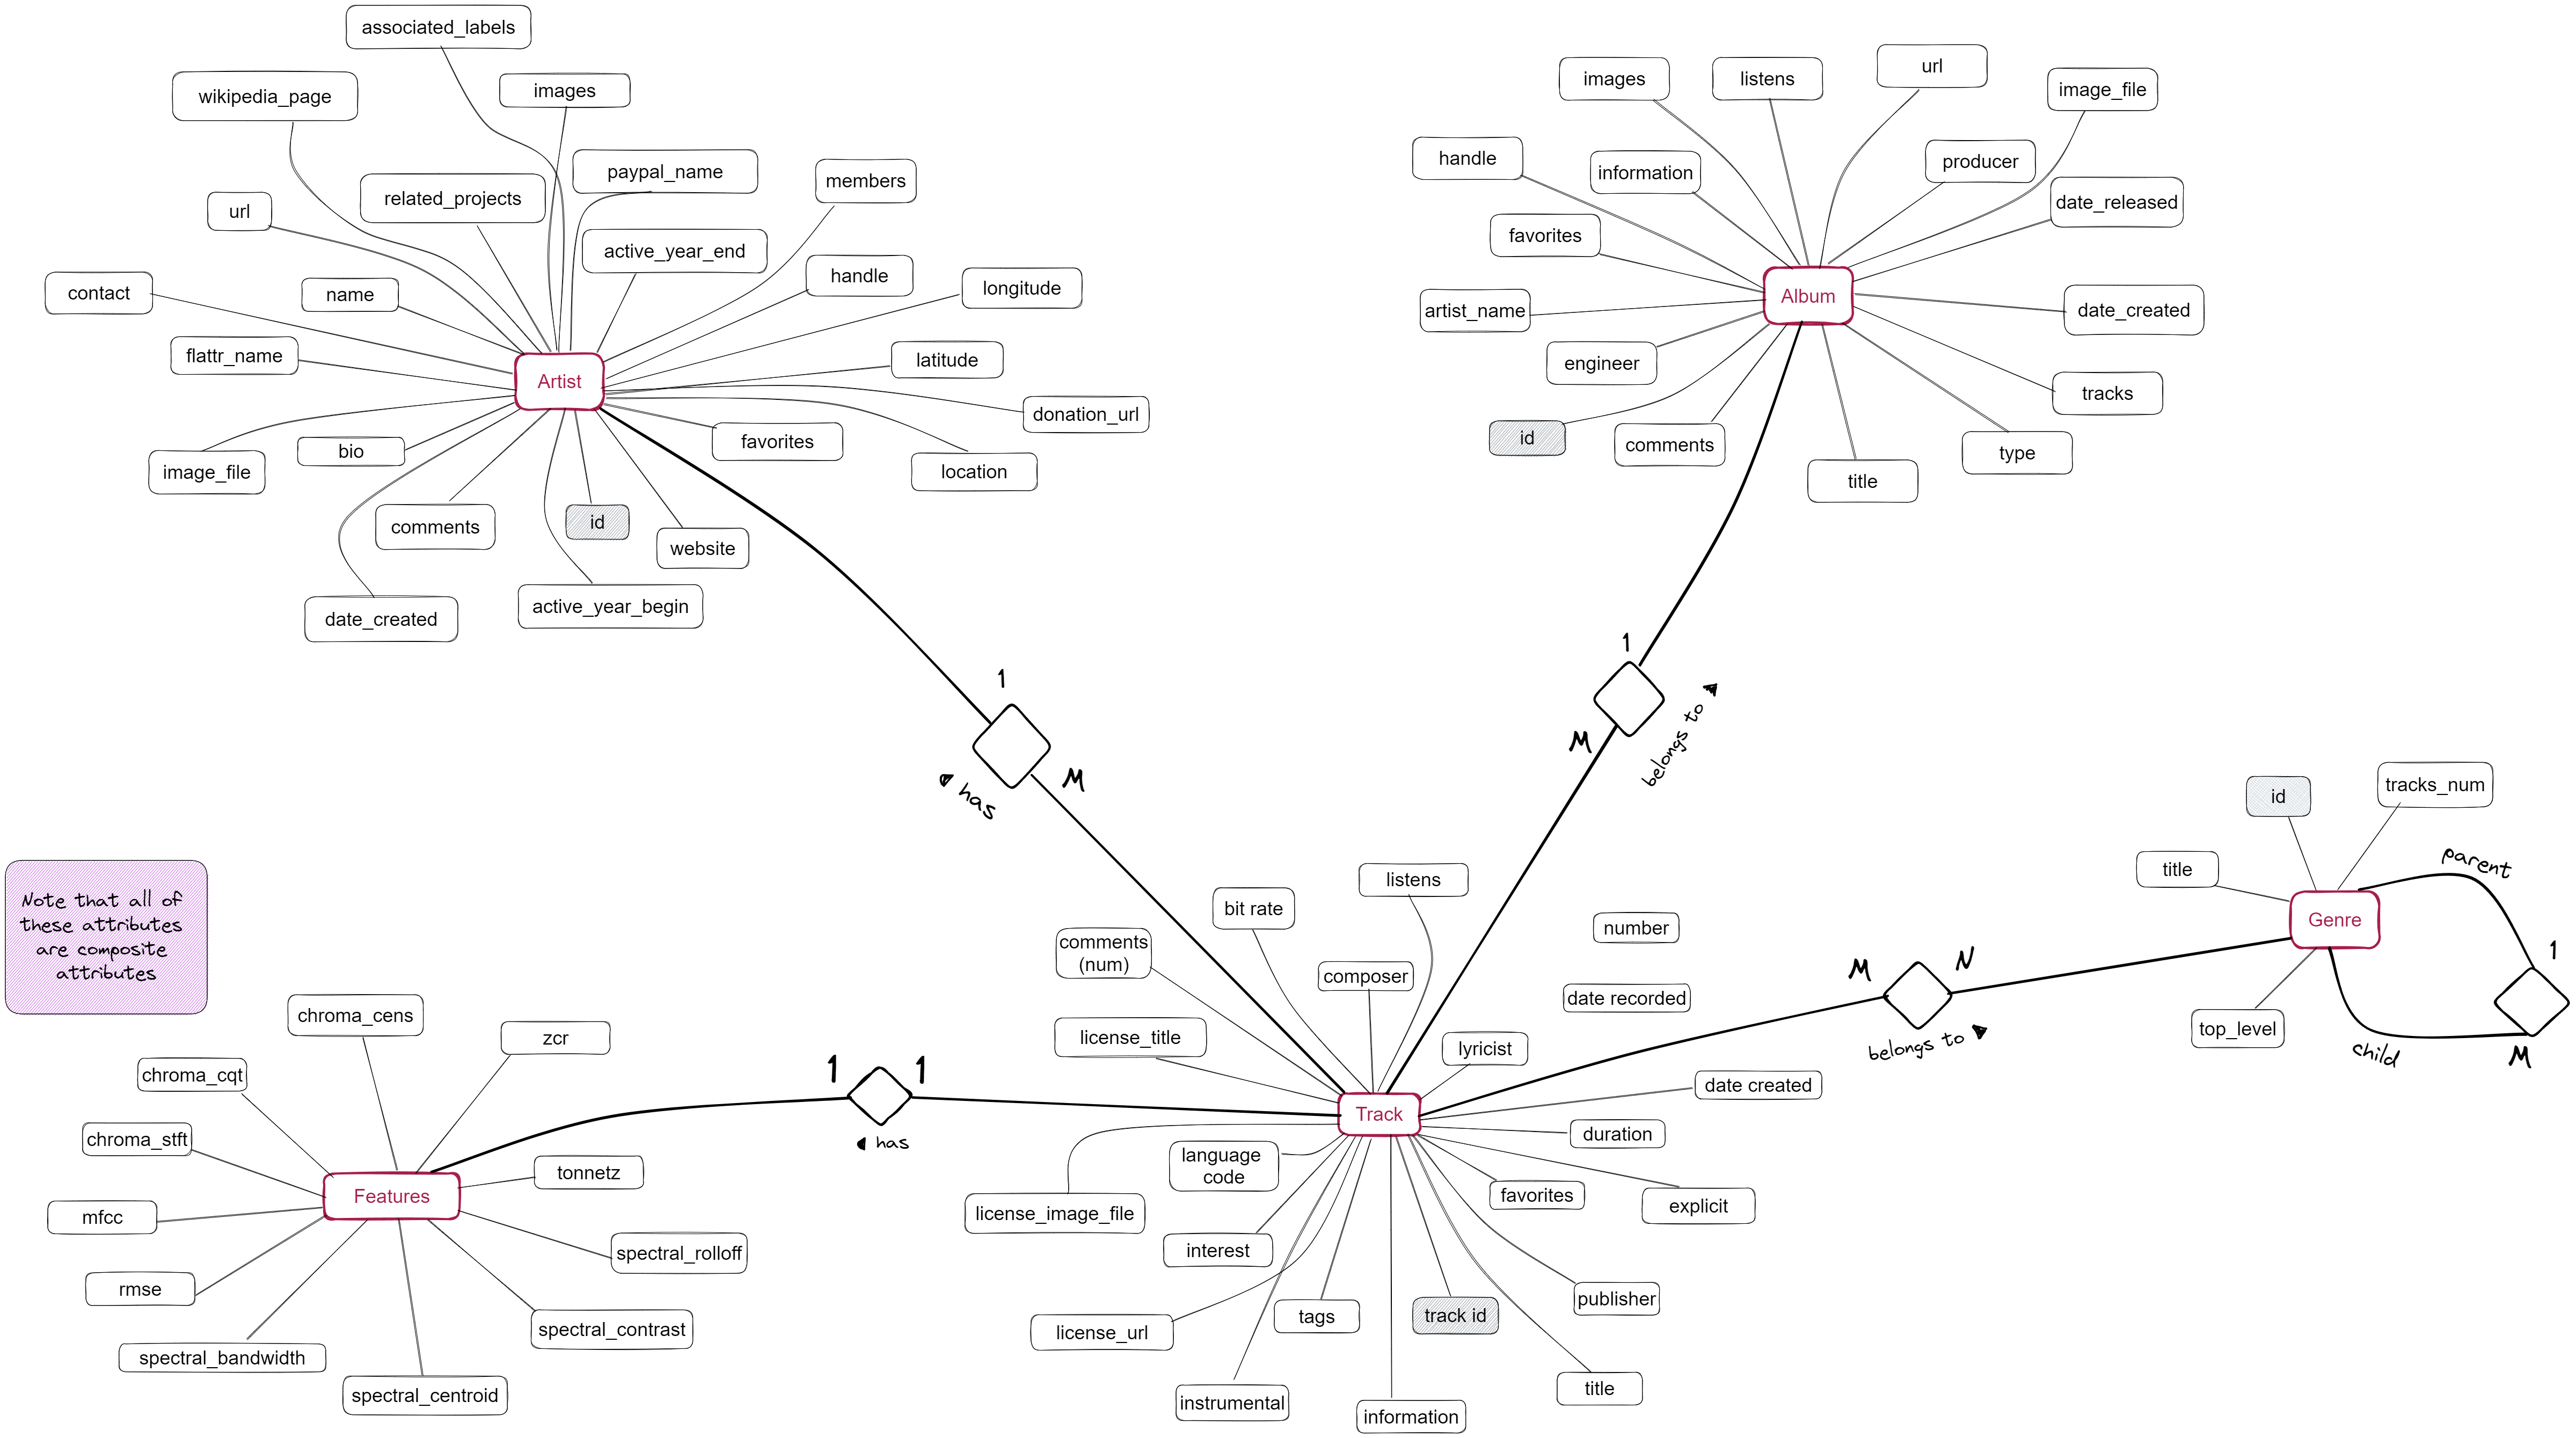

In [242]:
ipd.Image("images/informalER.png")

In [243]:
tracks = pd.read_csv(TRACKS_PATH, index_col=0)
artists = pd.read_csv(ARTISTS_PATH, index_col=0)
albums = pd.read_csv(ALBUMS_PATH, index_col=0)
features = pd.read_csv(FEATURES_PATH, index_col=0, header=[0, 1, 2])
genres = pd.read_csv(GENRES_PATH, index_col=0)

all_dfs = [tracks, albums, artists, genres, features]

We can see that certain tracks have metadata available, but extracted audio features are absent.

In [244]:
dataframes_shapes = {col:[] for col in ['file_name', 'rows', 'features']}
for name, df in zip(['tracks', 'albums', 'artists', 'genres', 'features'], all_dfs):
    dataframes_shapes['file_name'].append(name)
    dataframes_shapes['rows'].append(df.shape[0])
    dataframes_shapes['features'].append(df.shape[1])
dataframes_shapes = pd.DataFrame(dataframes_shapes)
dataframes_shapes.set_index('file_name', inplace=True)
dataframes_shapes.sort_values(by='rows', ascending=False)

,rows,features
file_name,,
tracks,109727,38
features,106574,518
artists,16916,24
albums,15234,18
genres,163,4


# 2. Tracks

Eliminating the tracks for which we do not have audio features extracted

In [245]:
no_audio_features_indexes = (list(set(tracks.index) - set(features.index)))
tracks.drop(index=no_audio_features_indexes, axis=0, inplace=True)
print(f'{len(no_audio_features_indexes)} tracks have no audio features')

3153 tracks have no audio features


In [246]:
tracks.columns

Index(['album_id', 'album_title', 'album_url', 'artist_id', 'artist_name',
       'artist_url', 'artist_website', 'license_image_file',
       'license_image_file_large', 'license_parent_id', 'license_title',
       'license_url', 'tags', 'track_bit_rate', 'track_comments',
       'track_composer', 'track_copyright_c', 'track_copyright_p',
       'track_date_created', 'track_date_recorded', 'track_disc_number',
       'track_duration', 'track_explicit', 'track_explicit_notes',
       'track_favorites', 'track_file', 'track_genres', 'track_image_file',
       'track_information', 'track_instrumental', 'track_interest',
       'track_language_code', 'track_listens', 'track_lyricist',
       'track_number', 'track_publisher', 'track_title', 'track_url'],
      dtype='object')

Dropping the tracks for which we do not have a licence for redistribution

In [247]:
tracks_no_licence = tracks.query('license_title == "FMA-Limited: Download Only"').index
tracks.drop(index=tracks_no_licence, axis=0, inplace=True)

In [248]:
tracks_drop_cols = ['license_image_file', 'license_image_file_large', 'license_parent_id', 'license_url', 'track_file',
                    'track_image_file', 'track_url', 'album_url', 'artist_url', 'track_copyright_c',
                    'track_copyright_p', 'track_composer', 'track_lyricist', 'track_publisher', 'album_title',
                    'artist_name', 'artist_website', 'license_title']

In [249]:
tracks.drop(tracks_drop_cols, axis=1, inplace=True)

## 2.1 Missing Values

In [250]:
tracks['tags'] = tracks['tags'].replace('[]', np.nan)

In [251]:
tracks_mv = MissingValuesUtil(tracks)
tracks_mv.get_mvdf()

,count,proportion (%)
album_id,1025.0,0.961773
artist_id,0.0,0.000000
tags,83078.0,77.953347
track_bit_rate,105.0,0.098523
track_comments,0.0,0.000000
track_date_created,0.0,0.000000
track_date_recorded,100415.0,94.220917
track_disc_number,0.0,0.000000
track_duration,0.0,0.000000
track_explicit,103167.0,96.803160


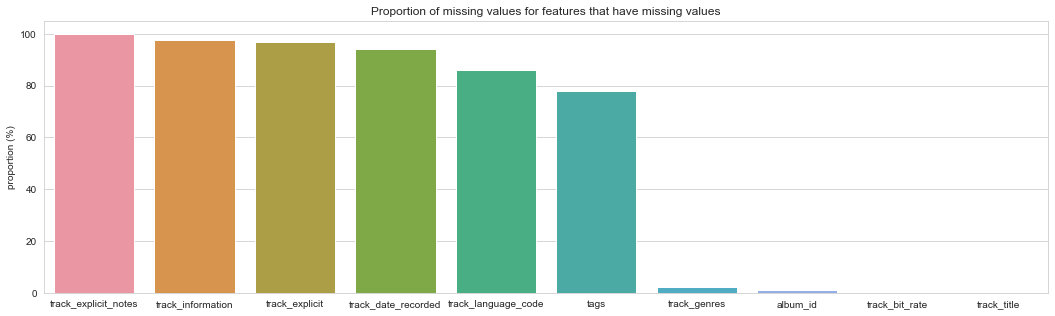

In [252]:
tracks_mv.barplot_mv(18,5)

Since the features "tags, track_date_recorded, track_explicit, track_explicit_notes, track_information, track_language_code" have a lot of missing values, we will exclude these features from the dataset.

In [253]:
features_missing_values = ['tags', 'track_date_recorded', 'track_explicit', 'track_explicit_notes', 'track_information', 'track_language_code']

In [254]:
print('Features with no missing values')
print(list(tracks_mv.features_no_mv()))

Features with no missing values
['artist_id', 'track_comments', 'track_date_created', 'track_disc_number', 'track_duration', 'track_favorites', 'track_instrumental', 'track_interest', 'track_listens', 'track_number']


In [255]:
tracks.drop(features_missing_values, axis=1, inplace=True)

Since one of our main objectives will be genre classification, it wouldn't make sense to impute these values and use them for training a model later

In [256]:
tracks.dropna(subset=['track_genres'], inplace=True)

In [257]:
tracks['album_id'].fillna(-1, inplace=True)
tracks['track_bit_rate'].fillna(-1, inplace=True)
tracks['track_title'].fillna('Untitled', inplace=True) # There are other Untitled tracks as well

## 2.2 Cleaning

Given that the majority of tracks have no comments, a value of 0 for track_instrumental, and a value of 1 for track_disc_number, we will drop these columns.

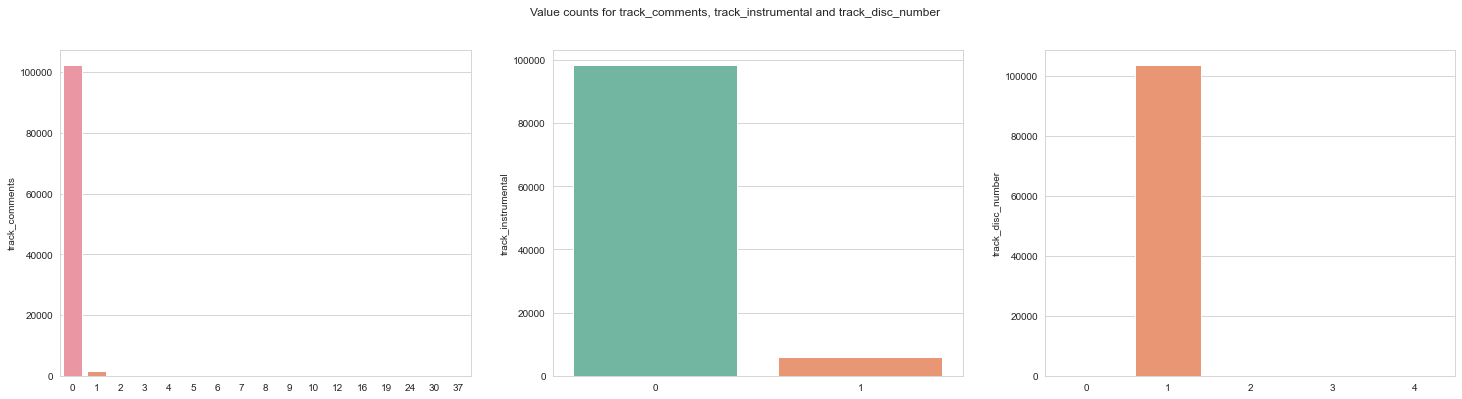

In [258]:
fig, axs = plt.subplots(1, 3, figsize=(25, 6))
sns.barplot(x=tracks['track_comments'].value_counts().index, y=tracks['track_comments'].value_counts(), ax=axs[0])
sns.barplot(x=tracks['track_instrumental'].value_counts().index, y=tracks['track_instrumental'].value_counts(), ax=axs[1])
sns.barplot(x=tracks['track_disc_number'].value_counts().index, y=tracks['track_disc_number'].value_counts(), ax=axs[2])
fig.suptitle('Value counts for track_comments, track_instrumental and track_disc_number')
plt.show()

In [259]:
tracks.drop(['track_comments', 'track_instrumental', 'track_disc_number'], axis=1, inplace=True)

In [260]:
def duration_to_seconds(duration):
    try:
        hours, minutes, seconds = map(int, duration.split(':'))
        return hours * 3600 + minutes * 60 + seconds
    except ValueError:
        minutes, seconds = map(int, duration.split(':'))
        return minutes * 60 + seconds

def convert_genres(genres):
    genres = ast.literal_eval(genres)
    return [int(genre['genre_id']) for genre in genres]

In [261]:
tracks['track_duration'] = tracks['track_duration'].map(duration_to_seconds)
tracks['genre_id'] = tracks['track_genres'].map(convert_genres)

tracks.drop('track_genres', axis=1, inplace=True)
tracks['track_date_created'] = pd.to_datetime(tracks['track_date_created'], infer_datetime_format=True)
tracks = tracks.astype({'album_id': int, 'track_bit_rate': int})

print(f'Number of missing values: {tracks.isna().sum().sum()}')
print(f' Number of features left: {tracks.shape[1]}')
print(f'     Number of rows left: {tracks.shape[0]}')

Number of missing values: 0
 Number of features left: 11
     Number of rows left: 104343


# 3. Artists

In [262]:
artists.tail(3)

,artist_active_year_begin,artist_active_year_end,artist_associated_labels,artist_bio,artist_comments,artist_contact,artist_date_created,artist_donation_url,artist_favorites,artist_flattr_name,...,artist_location,artist_longitude,artist_members,artist_name,artist_paypal_name,artist_related_projects,artist_url,artist_website,artist_wikipedia_page,tags
artist_id,,,,,,,,,,,,,,,,,,,,,
9994,2009.0,NaN,Death By Audio,"<p>Founded in 2008 by <strong><a href=""http://...",1,NaN,1/20/2011 04:07:49 PM,https://midheaven.com/item/wife-of-god-by-star...,3,NaN,...,"Brooklyn, NY 11211",-73.946415,Amy C. - Viola\nMike Gallope - Farfisa\nSam Ku...,Starring,NaN,Skeleton$\nThe Fancy\n,http://freemusicarchive.org/music/Starring/,http://www.myspace.com/starringband,NaN,['starring']
9995,2002.0,2007.0,"Phonomena, Mass Particles,",<p>Barry makes things and plays many things</p...,0,Chuck Bettis,1/20/2011 09:09:47 PM,NaN,0,NaN,...,New York (at least all were at that time),-74.007118,Chuck Bettis - electronics + throat\nToshio Ka...,Chuck Bettis/Toshio Kajiwara/Barry Weisblat,NaN,NaN,http://freemusicarchive.org/music/Chuck_Bettis...,www.chuckbettis.com,NaN,"['chuck bettis', 'barry weisblat', 'toshio kaj..."
9997,NaN,NaN,NaN,<p>precursor to the imminent Brown Wing Overdr...,0,chuck bettis,1/20/2011 11:55:58 PM,NaN,0,NaN,...,DC & VA,-77.014652,Chuck Bettis - electronics\nDerek Morton - ele...,Trance And The Arcade w/ Commie 64,NaN,Mikroknytes,http://freemusicarchive.org/music/Trance_And_T...,www.brownwingoverdrive.com,NaN,"['commie 64', 'trance and the arcade', 'derek ..."


In [263]:
artists_mv = MissingValuesUtil(artists)
artists_mv.get_mvdf()

,count,proportion (%)
artist_active_year_begin,15497.0,91.611492
artist_active_year_end,16446.0,97.221565
artist_associated_labels,15991.0,94.531804
artist_bio,10272.0,60.723575
artist_comments,0.0,0.000000
artist_contact,15460.0,91.392764
artist_date_created,0.0,0.000000
artist_donation_url,15332.0,90.636084
artist_favorites,0.0,0.000000
artist_flattr_name,16844.0,99.574367


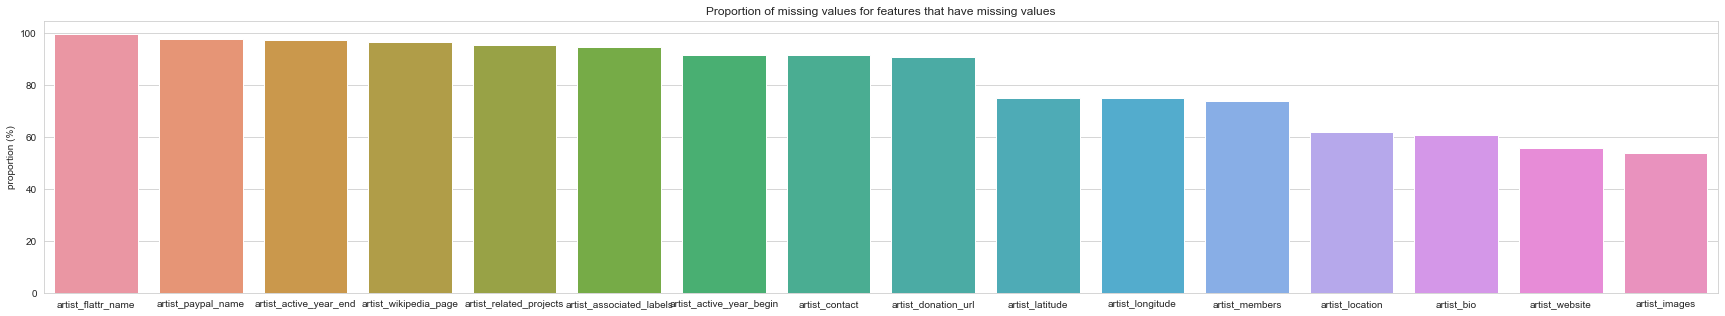

In [264]:
artists_mv.barplot_mv(30, 5)

In [265]:
print("Features with no missing values:")
print(list(artists_mv.features_no_mv()))

Features with no missing values:
['artist_comments', 'artist_date_created', 'artist_favorites', 'artist_handle', 'artist_image_file', 'artist_name', 'artist_url', 'tags']


In [266]:
artists_drop_cols = list(set(artists_mv.features_mv_only()) - {'artist_latitude', 'artist_longitude'})
artists_drop_cols += ['artist_handle', 'artist_image_file', 'tags']

In [267]:
artists.drop(artists_drop_cols, axis=1, inplace=True)
artists['artist_date_created'] = pd.to_datetime(artists['artist_date_created'], infer_datetime_format=True)

In [268]:
print(f'Number of missing values: {artists.isna().sum().sum()} (only for the latitude and longitude columns)')
print(f' Number of features left: {artists.shape[1]}')
print(f'     Number of rows left: {artists.shape[0]}')
print(f'    Number of duplicates: {artists.duplicated().sum()}')

Number of missing values: 25324 (only for the latitude and longitude columns)
 Number of features left: 7
     Number of rows left: 16916
    Number of duplicates: 0


# 4. Albums

In [269]:
albums.head(3)

,album_comments,album_date_created,album_date_released,album_engineer,album_favorites,album_handle,album_image_file,album_images,album_information,album_listens,album_producer,album_title,album_tracks,album_type,album_url,artist_name,artist_url,tags
album_id,,,,,,,,,,,,,,,,,,
1,0,11/26/2008 01:44:45 AM,1/05/2009,NaN,4,AWOL_-_A_Way_Of_Life,https://freemusicarchive.org/file/images/album...,"[{'image_id': '1955', 'image_file': 'https://f...",<p></p>,6073,NaN,AWOL - A Way Of Life,7,Album,http://freemusicarchive.org/music/AWOL/AWOL_-_...,AWOL,http://freemusicarchive.org/music/AWOL/,[]
100,0,11/26/2008 01:55:44 AM,1/09/2009,NaN,0,On_Opaque_Things,https://freemusicarchive.org/file/images/album...,"[{'image_id': '4403', 'image_file': 'https://f...",NaN,5613,NaN,On Opaque Things,4,Album,http://freemusicarchive.org/music/Bird_Names/O...,Bird Names,http://freemusicarchive.org/music/Bird_Names/,[]
1000,0,12/04/2008 09:28:49 AM,10/26/2008,NaN,0,DMBQ_Live_at_2008_Record_Fair_on_WFMU_Record_F...,https://freemusicarchive.org/file/images/album...,"[{'image_id': '31997', 'image_file': 'https://...",<p>http://blog.wfmu.org/freeform/2008/10/what-...,1092,NaN,DMBQ Live at 2008 Record Fair on WFMU Record F...,4,Live Performance,http://freemusicarchive.org/music/DMBQ/DMBQ_Li...,DMBQ,http://freemusicarchive.org/music/DMBQ/,[]


In [270]:
albums['tags'] = albums['tags'].replace('[]', np.nan)

In [271]:
albums_mv = MissingValuesUtil(albums)

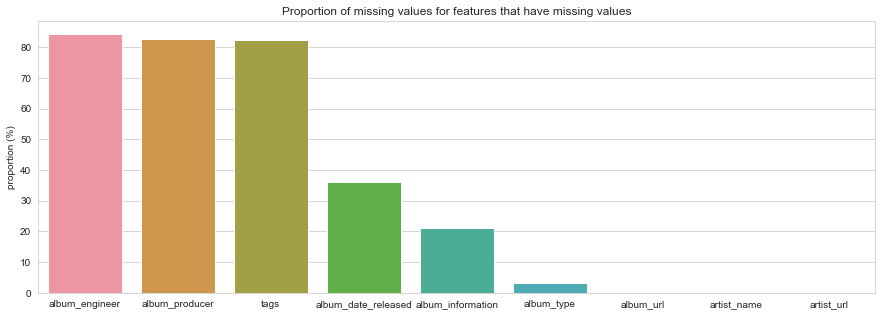

In [272]:
albums_mv.barplot_mv(15, 5)

In [273]:
albums_drop_cols = ['artist_name', 'album_url', 'artist_url', 'album_handle', 'album_image_file', 'album_images',
                    'album_producer', 'album_engineer', 'album_information', 'tags']

In [274]:
albums.drop(albums_drop_cols, axis=1, inplace=True)

In [275]:
albums['album_date_created'] = pd.to_datetime(albums['album_date_created'], infer_datetime_format=True)
albums['album_date_released'] = pd.to_datetime(albums['album_date_released'], infer_datetime_format=True)

In [276]:
MissingValuesUtil(albums).get_mvdf_missing_only()

,count,proportion (%)
album_date_released,5491.0,36.044374
album_type,464.0,3.045819


In [277]:
albums.duplicated().sum()

0

In [278]:
print(f'Number of missing values: {albums.isna().sum().sum()}')
print(f' Number of features left: {albums.shape[1]}')
print(f'     Number of rows left: {albums.shape[0]}')
print(f'    Number of duplicates: {albums.duplicated().sum()}')

Number of missing values: 5955
 Number of features left: 8
     Number of rows left: 15234
    Number of duplicates: 0


# 5. Genres

We will use the already preprocessed file for genres, since no additional changes are required for our purposes.

In [279]:
# The source of the dataset notes that genre 806 (hiphop) should not exist and should be substituted with 21 (Hip-Hop)
tracks['genre_id'] = tracks['genre_id'].map(lambda r: [genre if genre != 806 else 21 for genre in r])

In [280]:
top_level_genres = genres.query('parent == 0')

There are 16 top level genres

In [281]:
print(list(top_level_genres['title']))

['International', 'Blues', 'Jazz', 'Classical', 'Old-Time / Historic', 'Country', 'Pop', 'Rock', 'Easy Listening', 'Soul-RnB', 'Electronic', 'Folk', 'Spoken', 'Hip-Hop', 'Experimental', 'Instrumental']


In [282]:
n = np.sum(~tracks['genre_id'].isin(top_level_genres.index))
print(f'There are {n} tracks ({n / len(tracks) * 100.0}%) that are classified as belonging to a subgenre')

There are 104343 tracks (100.0%) that are classified as belonging to a subgenre


To simplify the genre classification process in the initial phase of the project, we plan to focus on categorizing each track into its "primary" genre. To accomplish this, we introduce a new attribute in the tracks dataframe that identifies the top-level genre. Although this represents a significant simplification, it serves as a good starting point for our work.

In [283]:
def get_top_level_genre(list_of_genres):
    top_genres = set(genres.at[genres.at[genre, 'top_level'], 'title'] for genre in list_of_genres) # multi-genre cases with same ancestor are also considered
    return top_genres.pop() if len(top_genres) == 1 else np.nan

In [284]:
tracks['genre_top'] = tracks['genre_id'].map(get_top_level_genre)

# 6. Univariate Analysis

## 6.1 Numerical Features

In [285]:
tracks.describe().T

,count,mean,std,min,25%,50%,75%,max
album_id,104343.0,12878.820803,6271.173656,-1.0,7855.0,13452.0,18230.0,22940.0
artist_id,104343.0,12026.978628,6893.011645,1.0,6443.0,11984.0,18018.0,24357.0
track_bit_rate,104343.0,263765.833424,67372.351394,-1.0,192000.0,314842.0,320000.0,448000.0
track_duration,104343.0,274.517265,294.038038,0.0,149.0,216.0,305.0,18350.0
track_favorites,104343.0,3.211878,13.622553,0.0,0.0,1.0,3.0,1482.0
track_interest,104343.0,3527.642401,18609.401300,2.0,609.0,1332.0,3087.0,3293557.0
track_listens,104343.0,2324.415926,7914.378974,1.0,297.0,775.0,2039.0,543252.0
track_number,104343.0,8.262682,15.031529,0.0,2.0,5.0,9.0,255.0


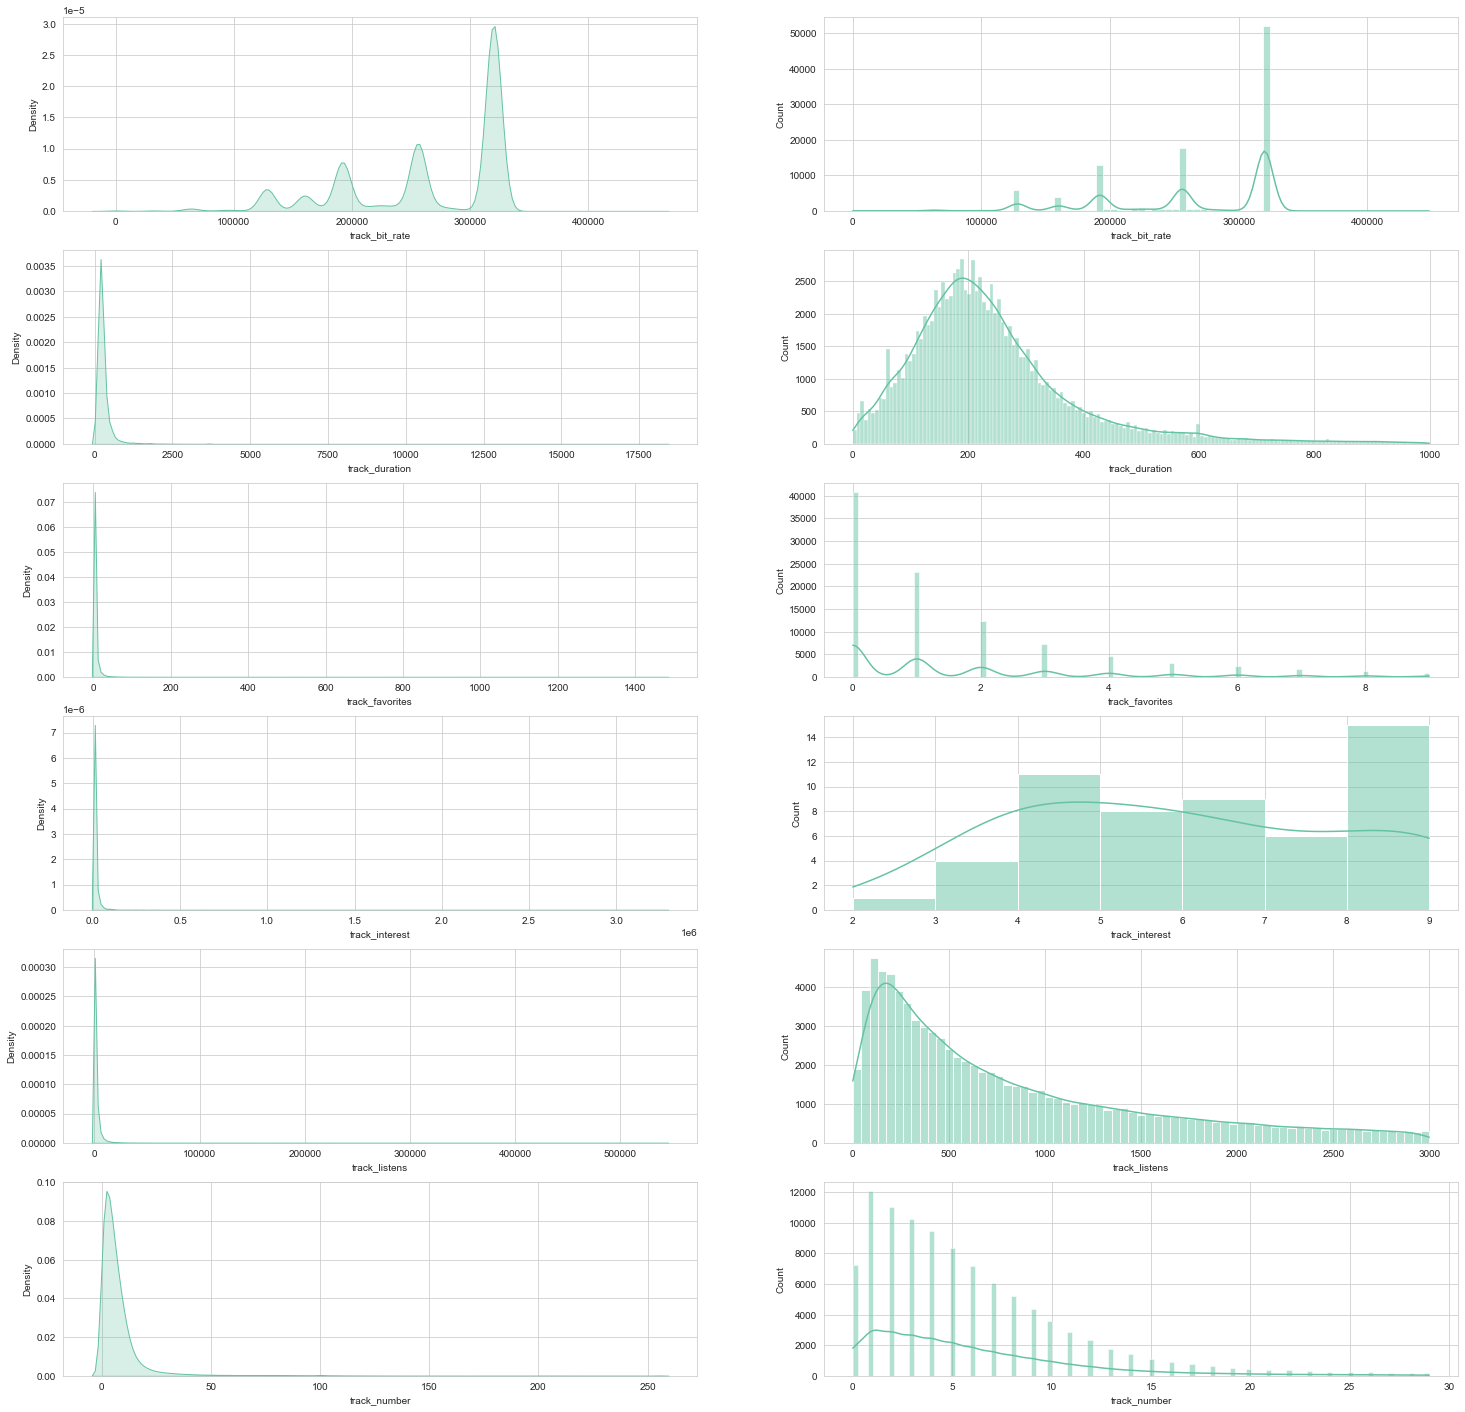

In [286]:
# the dictionary stores the pairs (feature, max value to be shown on histogram)
cols_to_plot = {'track_bit_rate': float('inf'), 'track_duration': 1000, 'track_favorites': 10, 'track_interest': 10,
                'track_listens': 3000, 'track_number': 30}

fig, axs = plt.subplots(6, 2, figsize=(25, 25))
subplots = list(range(6))
k = 0
for col, max_val in cols_to_plot.items():
    sns.kdeplot(tracks[col], ax=axs[subplots[k]][0], shade=True)
    sns.histplot(tracks[tracks[col] < max_val][col], ax=axs[subplots[k]][1], kde=True)
    k += 1
plt.show()

In [287]:
def count_outliers(df):
    Q1, Q3 = df.quantile(0.25), df.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = {col:0 for col in df.columns}
    for col in df.columns:
        outliers[col] += np.sum(((df[col] < lower_bound[col]) | (df[col] > upper_bound[col])))
    return pd.Series(outliers)

In [288]:
count_outliers(tracks[list(cols_to_plot.keys())])

track_bit_rate       104
track_duration      7327
track_favorites     9138
track_interest     10452
track_listens      11060
track_number        7202
dtype: int64

## 6.2 Categorical Features

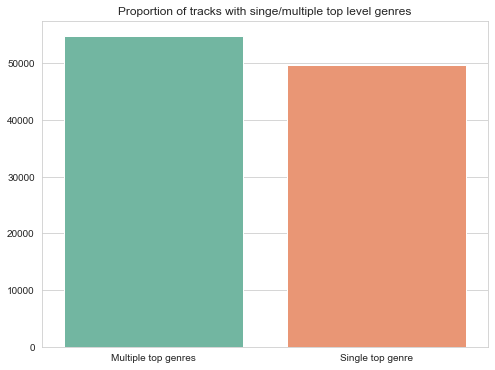

In [289]:
plt.figure(figsize=(8, 6))
sns.barplot(x=['Multiple top genres', 'Single top genre'], y=[tracks['genre_top'].isna().sum(), tracks['genre_top'].notnull().sum()])
plt.title('Proportion of tracks with singe/multiple top level genres')
plt.show()

There are 293 songs in the dataset that are titled "Untitled", and it appears that many of the other songs share a similar name, such as "3;2; Track 2", suggesting that the naming may not be coincidental.
Further inspection is needed for the audio features of such tracks.

In [290]:
duplicate_track_titles = tracks['track_title'].value_counts()
duplicate_track_titles[duplicate_track_titles > 2][:10]

Untitled                                     293
Into Infinity "ear" loop                     150
Intro                                        112
Interview                                     91
Chicken and Cheese 2 (Foot Village cover)     49
One Minute For The Stars                      36
jingles, interludes et dimanche minuit        34
Title Unknown                                 29
[interview]                                   29
Interlude                                     28
Name: track_title, dtype: int64

The class labels are unbalanced, so careful splitting of the data is necessary

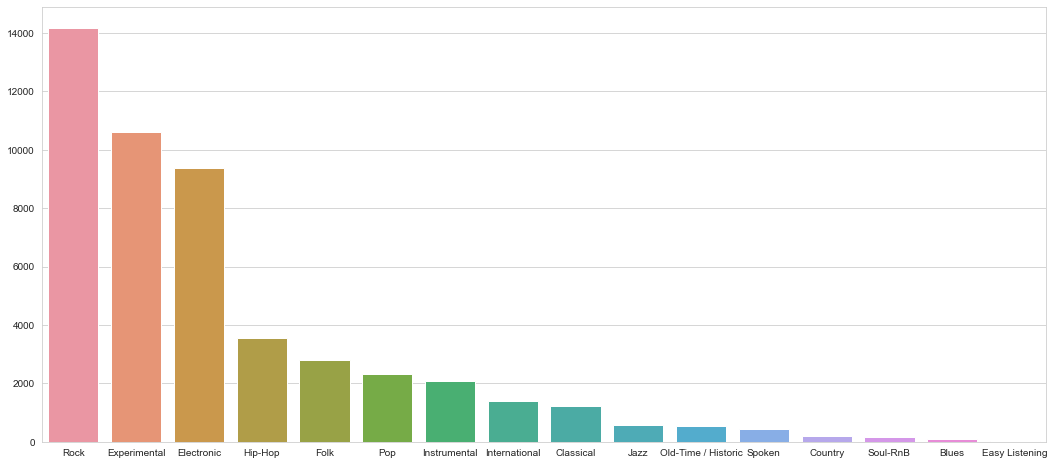

In [291]:
plt.figure(figsize=(18, 8))
sns.barplot(x=tracks['genre_top'].value_counts().index, y=tracks['genre_top'].value_counts().values)
plt.show()

In [292]:
genres_throughout_years = (
    tracks
    .groupby([tracks['track_date_created'].dt.year, tracks['genre_top']])
    .count()['track_title']
    .reset_index()
    .pivot(index='track_date_created', columns='genre_top', values='track_title')
    .T
)

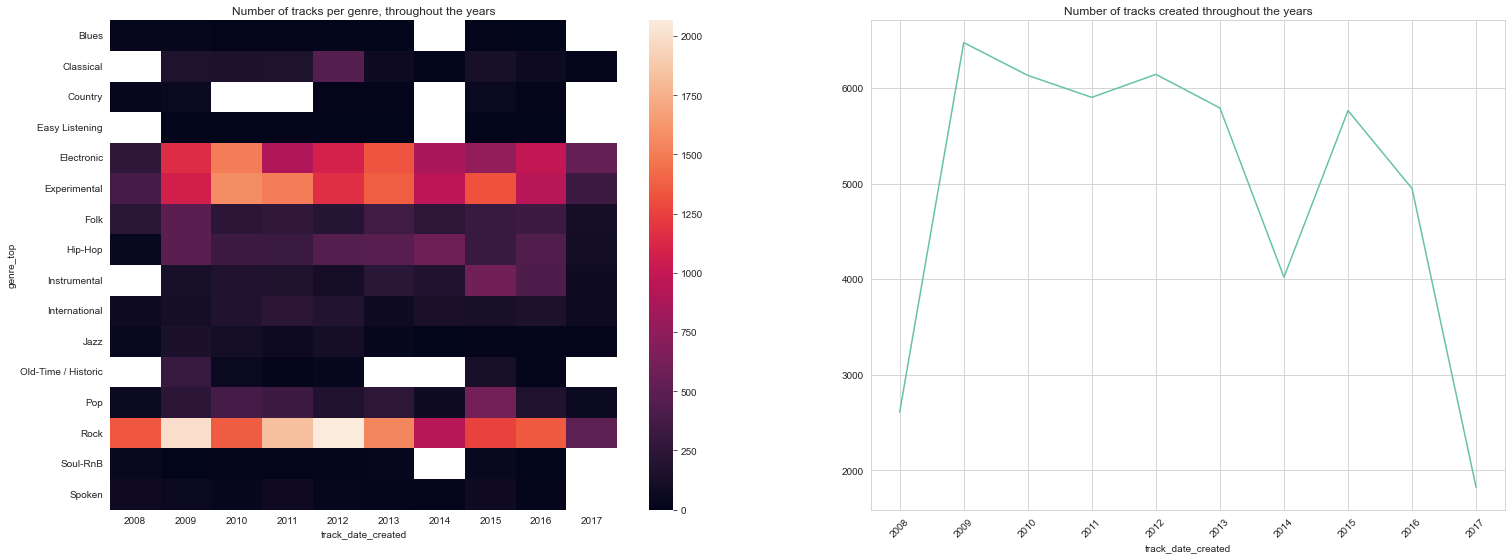

In [293]:
fig, axis = plt.subplots(1, 2, figsize=(25, 9))
sns.heatmap(genres_throughout_years, vmin=0, ax=axis[0])
sns.lineplot(x=genres_throughout_years.sum().index, y=genres_throughout_years.sum(), ax=axis[1])
axis[0].set_title('Number of tracks per genre, throughout the years')
axis[1].set_title('Number of tracks created throughout the years')
axis[1].set_xticks(genres_throughout_years.sum().index)
axis[1].set_xticklabels(genres_throughout_years.sum().index, rotation=45)
plt.show()

# 7. Multivariate Analysis

Choosing the tracks that are between 1 and 10 minutes seems reasonable, as most of the data would still be included

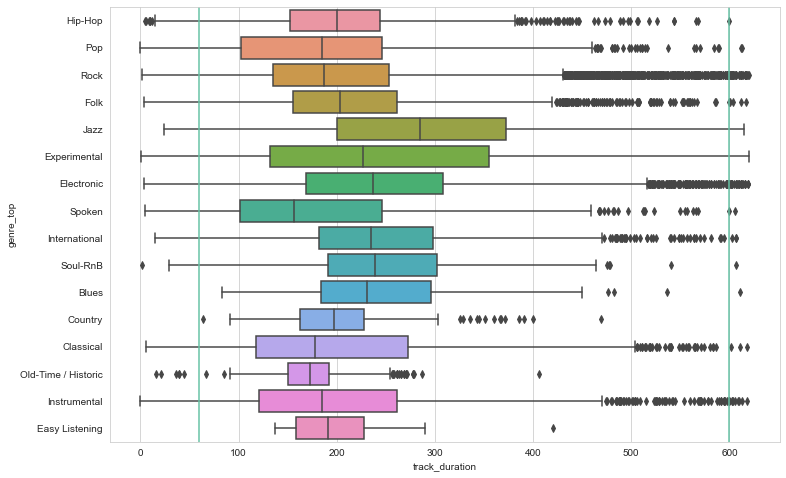

In [294]:
tracks_duration_temp = tracks['track_duration'] < tracks.quantile(0.95)['track_duration']
plt.figure(figsize=(12, 8))
sns.boxplot(x=tracks.loc[tracks_duration_temp, 'track_duration'], y=tracks.loc[tracks_duration_temp, 'genre_top'])
plt.axvline(x=600)
plt.axvline(x=60)
plt.show()

In [295]:
live_performances = albums.query('album_type == "Live Performance"').index
print(f'{np.sum(tracks["album_id"].isin(live_performances))} of the tracks are Live Performances')

4950 of the tracks are Live Performances


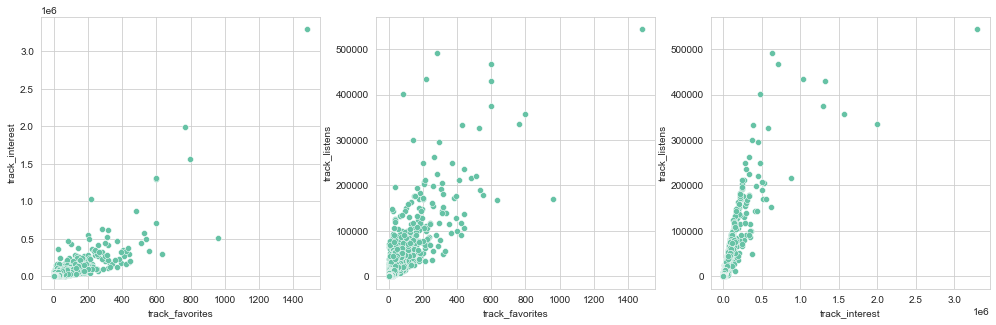

In [296]:
_, axis = plt.subplots(1, 3, figsize=(17, 5))
sns.scatterplot(x=tracks['track_favorites'], y=tracks['track_interest'], ax=axis[0])
sns.scatterplot(x=tracks['track_favorites'], y=tracks['track_listens'], ax=axis[1])
sns.scatterplot(x=tracks['track_interest'], y=tracks['track_listens'], ax=axis[2])
plt.show()

In [297]:
def popularity_score(df, weights):
    df_norm = df.apply(lambda col: col / col.max(), axis=0)
    return df_norm.dot(weights)

tracks['popularity_score'] = popularity_score(tracks[['track_interest', 'track_listens']], [0.35, 0.65])

In [298]:
tracks['popularity_score'].describe()

count    104343.000000
mean          0.003156
std           0.011167
min           0.000001
25%           0.000428
50%           0.001076
75%           0.002759
max           1.000000
Name: popularity_score, dtype: float64

<b>We will retain a subset of tracks based on the following criteria:</b>
- tracks that have a unique top level genre
- tracks that have a bit rate greater than 100kbps (to filter out tracks with low quality audio)
- tracks with duration between 1 and 10 minutes
- tracks that are relatively popular (scoring function)
- tracks that are NOT live performances (because of noise)
- tracks that do not have a title or have duplicate (suspicious) titles (further inspection is needed)

In [299]:
tracks = tracks[~tracks['genre_top'].isna()]
tracks = tracks.query('track_bit_rate > 100000')
tracks = tracks.query('track_duration > 60 and track_duration < 600')
tracks = tracks.query('album_id not in @live_performances')
tracks.shape

(40878, 13)

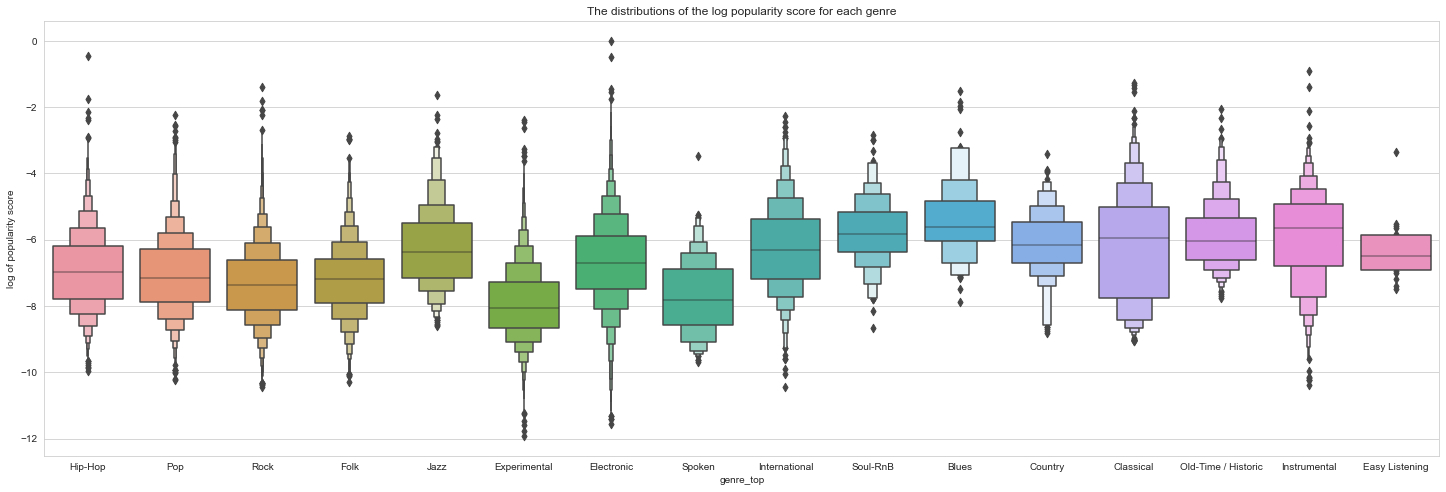

In [300]:
plt.figure(figsize=(25,8))
sns.boxenplot(x=tracks['genre_top'], y=np.log(tracks['popularity_score']))
plt.ylabel('log of popularity score')
plt.title('The distributions of the log popularity score for each genre')
plt.show()

In [301]:
tracks_reduced = tracks.query(f'popularity_score > {tracks["popularity_score"].quantile(0.25)}')

In [302]:
tracks_per_genre = pd.concat([tracks['genre_top'].value_counts(), tracks_reduced['genre_top'].value_counts()], axis=1).reset_index()
tracks_per_genre.columns = ['genre', '# before', '# after']
tracks_per_genre = pd.melt(tracks_per_genre, id_vars=['genre'], var_name='when', value_name='number')

Music genres such as Rock, Electronic, and particularly Experimental, have <b>lower</b> popularity ratings, resulting in a decrease in the number of tracks for these genres after the filtering process.

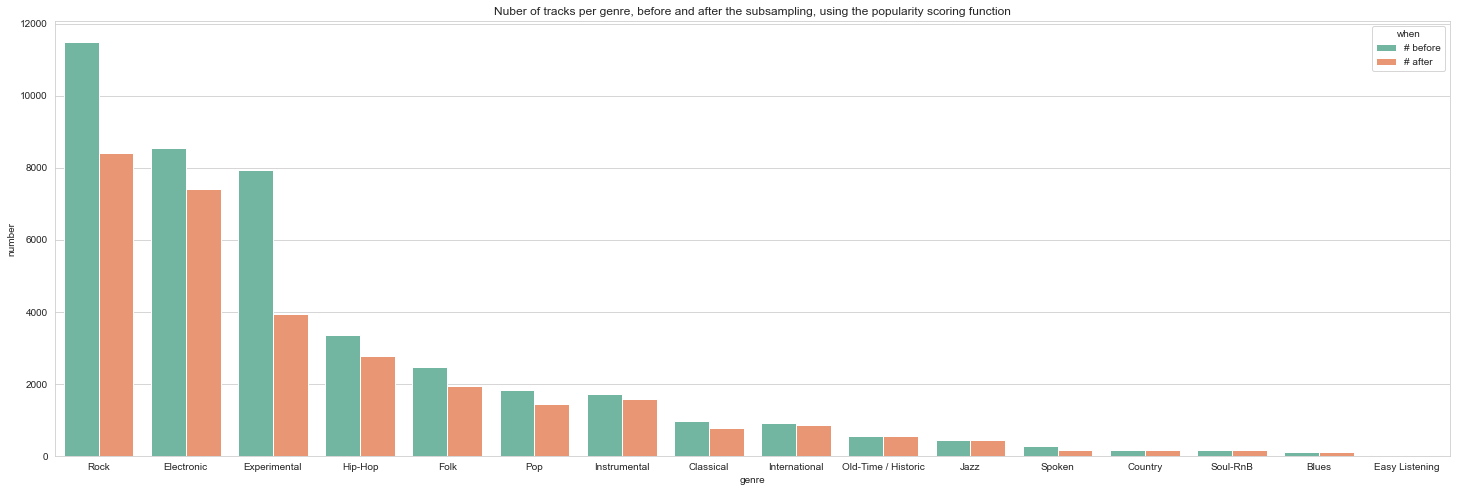

In [303]:
plt.figure(figsize=(25,8))
sns.barplot(data=tracks_per_genre, x='genre', y='number', hue='when')
plt.title("Nuber of tracks per genre, before and after the subsampling, using the popularity scoring function")
plt.show()

In [304]:
tracks = tracks_reduced

In [305]:
tracks.shape

(30658, 13)

# 8. Storing the processed data

In [306]:
ipd.display(tracks.head(2))
ipd.display(albums.head(2))
ipd.display(artists.head(2))

,album_id,artist_id,track_bit_rate,track_date_created,track_duration,track_favorites,track_interest,track_listens,track_number,track_title,genre_id,genre_top,popularity_score
track_id,,,,,,,,,,,,,
2,1,1,256000,2008-11-26 01:48:12,168,2,4656,1293,3,Food,[21],Hip-Hop,0.002042
3,1,1,256000,2008-11-26 01:48:14,237,1,1470,514,4,Electric Ave,[21],Hip-Hop,0.000771


,album_comments,album_date_created,album_date_released,album_favorites,album_listens,album_title,album_tracks,album_type
album_id,,,,,,,,
1,0,2008-11-26 01:44:45,2009-01-05,4,6073,AWOL - A Way Of Life,7,Album
100,0,2008-11-26 01:55:44,2009-01-09,0,5613,On Opaque Things,4,Album


,artist_comments,artist_date_created,artist_favorites,artist_latitude,artist_longitude,artist_name,artist_url
artist_id,,,,,,,
1,0,2008-11-26 01:42:32,9,40.058324,-74.405661,AWOL,http://freemusicarchive.org/music/AWOL/
10,3,2008-11-26 01:43:35,111,34.052234,-118.243685,Lucky Dragons,http://freemusicarchive.org/music/Lucky_Dragons/


In [307]:
tracks.to_csv(TRACKS_PATH_PROCESSED)
albums.to_csv(ALBUMS_PATH_PROCESSED)
artists.to_csv(ARTISTS_PATH_PROCESSED)

TODO:
- scrape data for missing album_type
- Plot the Genre hierarchy tree
- Cross-correlation matrix